**Shaik Mohammed Sayeed - CS19BTECH11004**

**Gantasala Naga Aneesh Ajaroy - CS19BTECH11010**

**Peddi Naga Hari Teja - CS19BTECH11021**

**Vemulapalli Aditya - CS19BTECH11025**

**Appanagari Sathwik Chakravarthi - ES19BTECH11008**

# **Importing Libraries**

In [101]:
import time
import argparse
import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

from __future__ import print_function
%matplotlib inline

# **Parameters**

In [102]:
trainingBatchSize = 64
testBatchSize = 1000

epochs = 5
noOfClasses = 10
learningRate = 0.01
momentum = 0.5

epsilon = 0.02

torch.manual_seed(1)

# **Training and Test DataSets**

In [103]:
kwargs = {}

trainingDataSet = datasets.MNIST( '../data', train=True, download=True, 
                                  transform=transforms.Compose( [transforms.ToTensor(),
                                                                 transforms.Normalize( (0.1307,), (0.3081,) )] )
                                )

trainingLoader = torch.utils.data.DataLoader( trainingDataSet, batch_size=trainingBatchSize, shuffle=True, **kwargs )

testDataSet = datasets.MNIST( '../data', train=False, download=True,
                              transform=transforms.Compose( [transforms.ToTensor(),
                                                             transforms.Normalize( (0.1307,), (0.3081,) )] )
                            )

testLoader = torch.utils.data.DataLoader( testDataSet, batch_size=testBatchSize, shuffle=True, **kwargs )

In [106]:
train_subset, val_subset = torch.utils.data.random_split(
        trainingDataSet, [50000, 10000], generator=torch.Generator().manual_seed(1))

In [107]:
maml_X_train = train_subset.dataset.data[train_subset.indices]
maml_Y_train = train_subset.dataset.targets[train_subset.indices]

maml_X_val = val_subset.dataset.data[val_subset.indices]
maml_Y_val = val_subset.dataset.targets[val_subset.indices]

In [108]:
maml_X_train = maml_X_train.unsqueeze(1)
maml_X_train = maml_X_train.type(torch.float32)
maml_X_val = maml_X_train.unsqueeze(1)
maml_X_val = maml_X_train.type(torch.float32)

# **CNN**

In [109]:
class ConvolutionalNN (nn.Module):

    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        
        self.convLayr1 = nn.Conv2d(1, 10, kernel_size=5)
        self.convLayr2 = nn.Conv2d(10, 20, kernel_size=5)
        self.convLayr2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward (self, x):
        x = F.relu(F.max_pool2d(self.convLayr1(x), 2))
        x = F.relu(F.max_pool2d(self.convLayr2_drop(self.convLayr2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# **Generating Adversarial Train and Test DataSets**

In [110]:
class CustomDataset(torch.utils.data.Dataset):
     def __init__(self, dataSet, labels):
         super(torch.utils.data.Dataset, self).__init__()
         self.start = 0
         self.end = len(dataSet) - 1
         self.dataSet = dataSet
         self.labels = labels
        
     def __len__(self):
         return self.end - self.start + 1
        
     def __getitem__(self, index):
        return self.dataSet[index], self.labels[index]

In [111]:
"""
Returns X_adv which is of type torch.float32 which is same as that of X_train
"""

def genAdversarialDataSet (trainingLoader, optimizerName, epsilon):

    model = ConvolutionalNN ()
    if ( optimizerName == "SGD"):
        optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=momentum)
    
    X_adv_final = []

    for X_train, Y_train in trainingLoader:
        X_train, Y_train = Variable(X_train, requires_grad=True), Variable(Y_train)
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = F.nll_loss(predictions, Y_train)
        loss.backward()
        optimizer.step()
                    
        X_grad = torch.sign(X_train.grad.data)
        X_adv = torch.clamp(X_train.data + epsilon * X_grad, 0, 1)

        X_adv_final.append(X_adv)

    return torch.cat(X_adv_final)

In [112]:
"""
Returns X_adv which is of type torch.float32 which is same as that of X_train
"""

def genAdversarialData (model, X_train, Y_train, optimizerName, epsilon):

    tempModel = ConvolutionalNN ()
    tempModel.convLayr1.weight = model.convLayr1.weight
    tempModel.convLayr2.weight = model.convLayr2.weight
    tempModel.fc1.weight = model.fc1.weight
    tempModel.fc2.weight = model.fc2.weight

    if ( optimizerName == "SGD"):
        optimizer = optim.SGD(tempModel.parameters(), lr=learningRate, momentum=momentum)
    
    X_train, Y_train = Variable(X_train, requires_grad=True), Variable(Y_train)
    optimizer.zero_grad()
    predictions = tempModel(X_train)
    loss = F.nll_loss(predictions, Y_train)
    loss.backward()
    optimizer.step()
                
    X_grad = torch.sign(X_train.grad.data)
    X_adv = torch.clamp(X_train.data + epsilon * X_grad, 0, 1)

    return X_adv

In [113]:
advTrainData = genAdversarialDataSet(trainingLoader, "SGD", epsilon)

In [114]:
advTrainingData = CustomDataset (advTrainData, trainingDataSet.targets)
# advTrainingLoader = torch.utils.data.DataLoader(advTrainingData, batch_size=trainingBatchSize, shuffle=True)
advTrainingLoader = torch.utils.data.DataLoader(advTrainingData, batch_size=trainingBatchSize, shuffle=False)

In [115]:
advTestData = genAdversarialDataSet(testLoader, "SGD", epsilon)

In [116]:
advTestData = CustomDataset (advTestData, testDataSet.targets)
# advTestLoader = torch.utils.data.DataLoader(advTestData, batch_size=testBatchSize, shuffle=True)
advTestLoader = torch.utils.data.DataLoader(advTestData, batch_size=testBatchSize, shuffle=False)

In [117]:
train_subset, val_subset = torch.utils.data.random_split(
        advTrainingData, [50000, 10000], generator=torch.Generator().manual_seed(1))

In [118]:
maml_X_adv_train = train_subset.dataset.dataSet[train_subset.indices]
maml_Y_adv_train = train_subset.dataset.labels[train_subset.indices]

maml_X_adv_val = val_subset.dataset.dataSet[val_subset.indices]
maml_Y_adv_val = val_subset.dataset.labels[val_subset.indices]

In [119]:
maml_X_adv_train = maml_X_adv_train.unsqueeze(1)
maml_X_adv_train = maml_X_adv_train.type(torch.float32)
maml_X_adv_val = maml_X_adv_train.unsqueeze(1)
maml_X_adv_val = maml_X_adv_train.type(torch.float32)

# **Testing the Model**

In [120]:
def test (model, testLoader):

    model.eval()

    testLoss = 0
    correct = 0

    for data, labels in testLoader:

        with torch.no_grad():
            predictions = model(data)
            testLoss += F.nll_loss(predictions, labels, reduction='sum').item()
            predLabels = predictions.data.max(1, keepdim=True)[1]

            # ???
            correct += predLabels.eq(labels.data.view_as(predLabels)).sum().item()

    testLoss /= len(testLoader.dataset)
    accuracy = correct / len(testLoader.dataset)

    return testLoss, accuracy

    # print("Test Loss (average) : {:.4f}".format(testLoss))
    # print("Test Accuracy : {}".format(accuracy))

# **Training the Model**

In [139]:
def train (model, trainingLoader, testLoader, epochs, optimizerName, displayResults=False):
    
    model.train()
    printInterval = 10

    if ( optimizerName == "SGD" ):
        optimizer = optim.SGD(normalModel.parameters(), lr=learningRate, momentum=momentum)

    trainingLosses = []
    trainingAccuracies = []
    testLosses = []
    testAccuracies = []

    for epoch in range(epochs):

        print("Training EpochNo : {}".format(epoch+1))

        trainingLoss = 0
        correct = 0

        for batchNo, (data, labels) in enumerate(trainingLoader):
                
            data, labels = Variable(data), Variable(labels)
            optimizer.zero_grad()
            predictions = model(data)
            loss = F.nll_loss(predictions, labels)
            predLabels = predictions.data.max(1, keepdim=True)[1]
            correct += predLabels.eq(labels.data.view_as(predLabels)).sum().item()
            loss.backward()
            optimizer.step()

            # if (displayResults == True):
            #     if ((batchNo % printInterval) == 0):
            #         print('[{}/{} ({:.0f}%)]  Loss: {:.6f}'.format( batchNo*len(data), len(trainingLoader.dataset), 
            #                                                         (100. * batchNo / len(trainingLoader)), loss.item() 
            #                                                     ) )
                    
            trainingLoss += loss.item()
        
        trainingLoss /= len(trainingLoader.dataset)
        trainingLosses.append(trainingLoss)
        trainingAccuracy = correct / len(trainingLoader.dataset)
        trainingAccuracies.append(trainingAccuracy)
        testLoss, testAccuracy = test (model, testLoader)
        testLosses.append(testLoss)
        testAccuracies.append(testAccuracy)

    epochNos = list(range(1, epochs+1))

    fig, ax = plt.subplots(2, 2, figsize=(8,8))
    ax[0,0].plot(epochNos, trainingLosses)
    ax[0,0].set_title("Training Data")
    ax[0,0].set_xlabel("Epoch No")
    ax[0,0].set_ylabel("Average Loss")

    ax[0,1].plot(epochNos, trainingAccuracies)
    ax[0,1].set_title("Training Data")
    ax[0,1].set_xlabel("Epoch No")
    ax[0,1].set_ylabel("Training Accuracy")

    ax[1,0].plot(epochNos, testLosses)
    ax[1,0].set_title("Test Data")
    ax[1,0].set_xlabel("Epoch No")
    ax[1,0].set_ylabel("Average Loss")

    ax[1,1].plot(epochNos, testAccuracies)
    ax[1,1].set_title("Test Data")
    ax[1,1].set_xlabel("Epoch No")
    ax[1,1].set_ylabel("Test Accuracy")

    fig.tight_layout()
    plt.show()


# **Normal Model**

In [140]:
normalModel = ConvolutionalNN()

Training EpochNo : 1
Training EpochNo : 2
Training EpochNo : 3
Training EpochNo : 4
Training EpochNo : 5


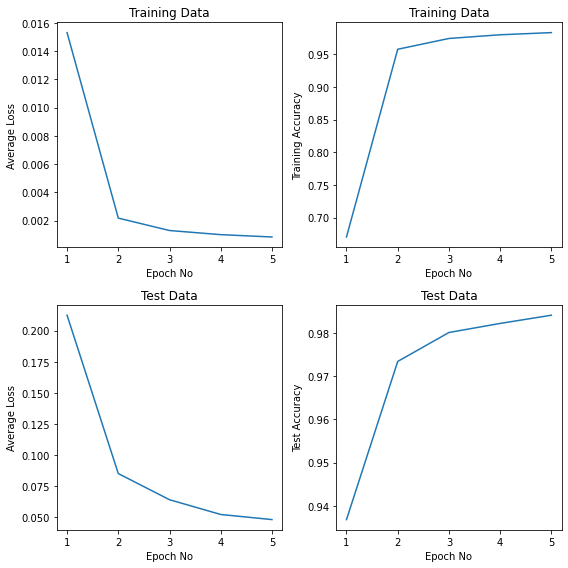

In [141]:
train(normalModel, trainingLoader, testLoader, epochs, "SGD")

In [144]:
# test(normalModel, testLoader)

In [143]:
testLoss, testAccuracy = test(normalModel, advTestLoader)
print("Test Loss : {}".format(testLoss))
print("Test Accuracy : {}".format(testAccuracy))

Test Loss : 4.604381640625
Test Accuracy : 0.1046


# **Visualize Adveresarial Example**

In [145]:
def reverseNormalize (img):
    img = img.view(28,28)
    img = img.mul(torch.FloatTensor([0.3081,]))
    img = img.add(torch.FloatTensor([0.1307,]))
    img = img.numpy()
    return img

In [146]:
def visualize(img, imgAdv, imgGrad, epsilon, imgCleanPred, imgAdvPred, cleanProb, advProb):
    
    # Reverse of Normalization        
    img = reverseNormalize(img)
    imgAdv = reverseNormalize(imgAdv)
    imgGrad = imgGrad.view(28,28).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    axes[0].imshow(img)
    axes[0].set_title('Clean Example', fontsize=22)
    axes[0].axis('off')
    
    axes[1].imshow(imgGrad)
    axes[1].set_title('Perturbation', fontsize=22)
    axes[1].set_yticklabels([])
    axes[1].set_xticklabels([])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    axes[2].imshow(imgAdv)
    axes[2].set_title('Adversarial Example', fontsize=22)
    axes[2].axis('off')

    axes[0].text(1.1, 0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", transform=axes[0].transAxes)
    axes[0].text(0.5, -0.13, "Prediction: {}\n Probability: {}".format(imgCleanPred, cleanProb), size=15, ha="center", transform=axes[0].transAxes)
    axes[1].text(1.1, 0.5, " = ", size=15, ha="center", transform=axes[1].transAxes)
    axes[2].text(0.5, -0.13, "Prediction: {}\n Probability: {}".format(imgAdvPred, advProb), size=15, ha="center", transform=axes[2].transAxes)

    plt.show()

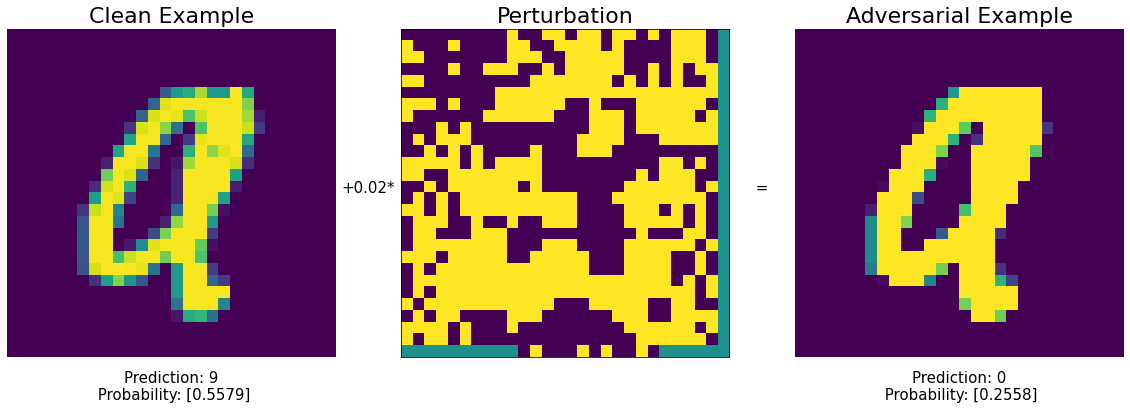

In [147]:
trainingDataIter = iter(trainingLoader)

model = normalModel

# the next element is the first element
images, labels = trainingDataIter.next()

for i in range (images.shape[0]):

    img = images[i]
    label = labels[i]
    ximg = torch.Tensor(img)

    # Returns a new tensor with a dimension of size one inserted at the specified position
    img = img.unsqueeze(0)

    img = Variable(img, requires_grad=True)

    # Why Long Tensor ???
    label = Variable(torch.LongTensor([label]), requires_grad=False)

    prediction = model(img)
    imgCleanPred = torch.max(prediction.data, 1)[1][0]

    #output is log_softmax so in order to get probs take 'exp' of it.
    cleanProbs = np.exp(prediction.data)
    cleanProb = cleanProbs[:,imgCleanPred]

    loss = F.nll_loss(prediction, label)
    loss.backward()

    #generate the adversarial example using formula, also clip it to make it a valid image
    epsilon = 0.02
    imgGrad = torch.sign(img.grad.data)
    imgAdv = torch.clamp(img.data + epsilon * imgGrad, 0, 1)

    prediction = model(Variable(imgAdv))
    imgAdvPred = torch.max(prediction.data,1)[1][0]

    advProbs = np.exp(prediction.data)
    advProb = advProbs[:,imgAdvPred]

    if ( (imgCleanPred == labels[i]) and (imgCleanPred != imgAdvPred) ):
        visualize(img.data, imgAdv, imgGrad, epsilon, imgCleanPred, imgAdvPred, np.around(cleanProb.numpy(), 4), np.around(advProb.numpy(), 4))
        break

# **Adversarial Model**

In [148]:
advModel = ConvolutionalNN ()

In [149]:
def adversarialTrain (model, trainingLoader, testLoader, advTrainingLoader, advTestLoader, epochs, optimizerName, displayResults=False):
    
    model.train()
    printInterval = 10

    if ( optimizerName == "SGD" ):
        optimizer = optim.SGD(normalModel.parameters(), lr=learningRate, momentum=momentum)

    trainingLosses = []
    trainingAccuracies = []
    advTrainingLosses = []
    advTrainingAccuracies = []
    testLosses = []
    testAccuracies = []
    advTestLosses = []
    advTestAccuracies = []

    for epoch in range(epochs):

        print("Training EpochNo : {}".format(epoch))

        trainingLoss = 0
        correct = 0

        advTrainingLoss = 0
        advCorrect = 0

        for batchNo, (data, labels) in enumerate(trainingLoader):

            X_train = data
            Y_train = labels
    
            data, labels = Variable(data), Variable(labels)
            optimizer.zero_grad()
            predictions = model(data)
            loss = F.nll_loss(predictions, labels)
            predLabels = predictions.data.max(1, keepdim=True)[1]
            correct += predLabels.eq(labels.data.view_as(predLabels)).sum().item()
            loss.backward()
            optimizer.step()

            trainingLoss += loss.item()

            X_adv = genAdversarialData (model, X_train, Y_train, optimizerName, epsilon) 

            X_adv = Variable(X_adv)
            optimizer.zero_grad()
            predictions = model(X_adv)
            loss = F.nll_loss(predictions, labels)
            predLabels = predictions.data.max(1, keepdim=True)[1]
            advCorrect += predLabels.eq(labels.data.view_as(predLabels)).sum().item()
            loss.backward()
            optimizer.step()

            if (displayResults == True):
                if ((batchNo % printInterval) == 0):
                    print('[{}/{} ({:.0f}%)]  Loss: {:.6f}'.format( batchNo*len(data), len(trainingLoader.dataset), 
                                                                    (100. * batchNo / len(trainingLoader)), loss.item() 
                                                                ) )
            advTrainingLoss += loss.item()    
            
        
        trainingLoss /= len(trainingLoader.dataset)
        trainingLosses.append(trainingLoss)
        trainingAccuracy = correct / len(trainingLoader.dataset)
        trainingAccuracies.append(trainingAccuracy)

        advTrainingLoss /= len(advTrainingLoader.dataset)
        advTrainingLosses.append(advTrainingLoss)
        advTrainingAccuracy = correct / len(advTrainingLoader.dataset)
        advTrainingAccuracies.append(advTrainingAccuracy)
        
        testLoss, testAccuracy = test (model, testLoader)
        advTestLoss, advTestAccuracy = test (model, advTestLoader)
        
        testLosses.append(testLoss)
        testAccuracies.append(testAccuracy)

        advTestLosses.append(advTestLoss)
        advTestAccuracies.append(advTestAccuracy)

    epochNos = list(range(1, epochs+1))

    fig, ax = plt.subplots(4, 2, figsize=(8,16))

    ax[0,0].plot(epochNos, trainingLosses)
    ax[0,0].set_title("Clean Training Data")
    ax[0,0].set_xlabel("Epoch No")
    ax[0,0].set_ylabel("Average Loss")

    ax[0,1].plot(epochNos, trainingAccuracies)
    ax[0,1].set_title("Clean Training Data")
    ax[0,1].set_xlabel("Epoch No")
    ax[0,1].set_ylabel("Training Accuracy")

    ax[1,0].plot(epochNos, advTrainingLosses)
    ax[1,0].set_title("Adversarial Training Data")
    ax[1,0].set_xlabel("Epoch No")
    ax[1,0].set_ylabel("Average Loss")

    ax[1,1].plot(epochNos, advTrainingAccuracies)
    ax[1,1].set_title("Adversarial Training Data")
    ax[1,1].set_xlabel("Epoch No")
    ax[1,1].set_ylabel("Training Accuracy")

    ax[2,0].plot(epochNos, testLosses)
    ax[2,0].set_title("Clean Test Data")
    ax[2,0].set_xlabel("Epoch No")
    ax[2,0].set_ylabel("Average Loss")

    ax[2,1].plot(epochNos, testAccuracies)
    ax[2,1].set_title("Clean Test Data")
    ax[2,1].set_xlabel("Epoch No")
    ax[2,1].set_ylabel("Test Accuracy")

    ax[3,0].plot(epochNos, advTestLosses)
    ax[3,0].set_title("Adversarial Test Data")
    ax[3,0].set_xlabel("Epoch No")
    ax[3,0].set_ylabel("Average Loss")

    ax[3,1].plot(epochNos, advTestAccuracies)
    ax[3,1].set_title("Adversarial Test Data")
    ax[3,1].set_xlabel("Epoch No")
    ax[3,1].set_ylabel("Test Accuracy")

    fig.tight_layout()

    plt.show()

Training EpochNo : 0
Training EpochNo : 1
Training EpochNo : 2
Training EpochNo : 3
Training EpochNo : 4


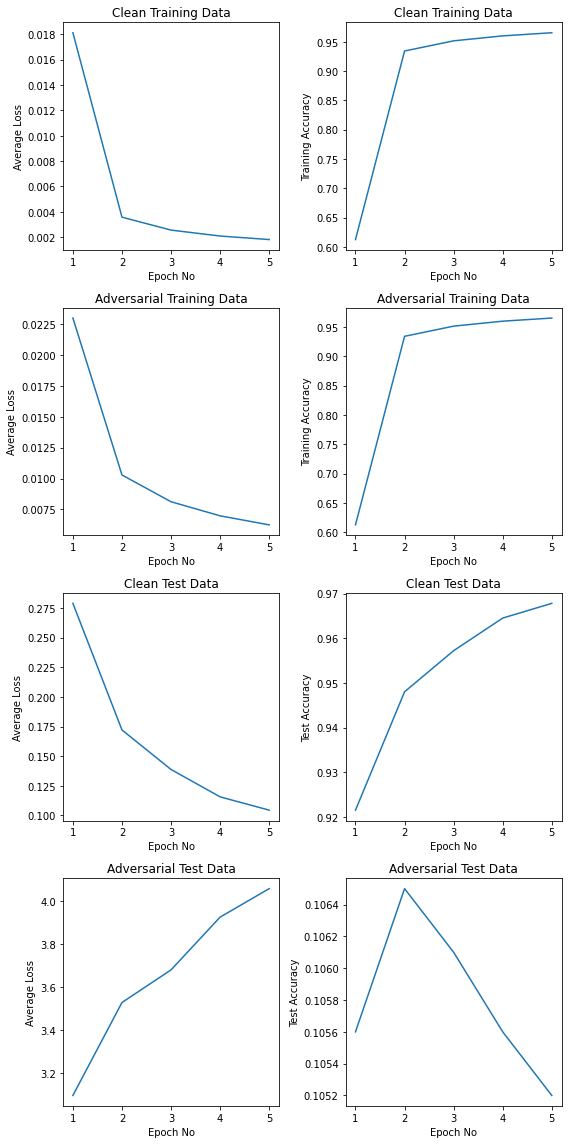

In [150]:
adversarialTrain (advModel, trainingLoader, testLoader, advTrainingLoader, advTestLoader, epochs, "SGD", displayResults=False)

In [151]:
# test(advModel, testLoader)

In [152]:
# test(advModel, advTestLoader)

# **Adversarial MAML model**

In [153]:
mamlModel = ConvolutionalNN ()

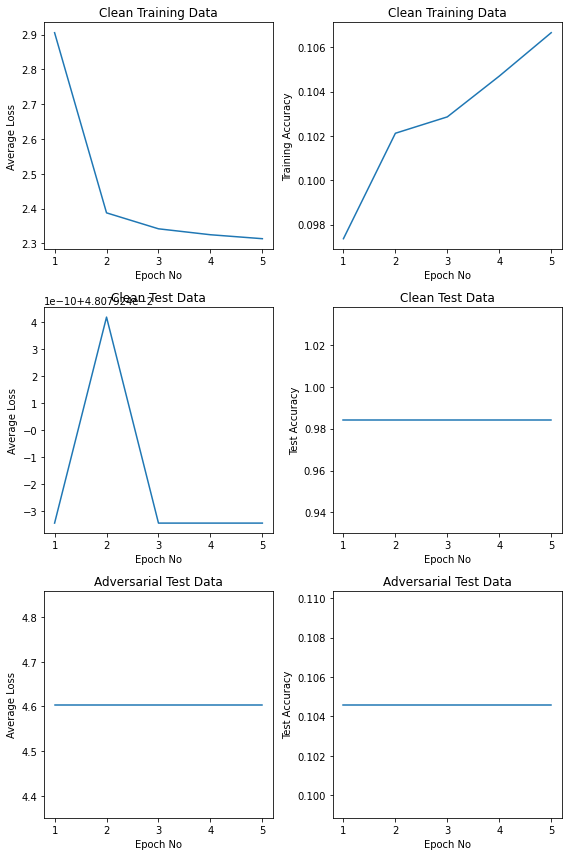

In [154]:
optimizer = optim.SGD(mamlModel.parameters(), lr=learningRate)

beta = 0.01

trainTaskSize = 50
valTaskSize = 10
noOfTasks = maml_X_train.shape[0] // trainTaskSize

trainingLosses = []
trainingAccuracies = []

testLosses = []
testAccuracies = []
advTestLosses = []
advTestAccuracies = []

for i in range (epochs):

    trainingLoss = 0
    correct = 0
    total = 0

    for taskNo in range(noOfTasks):

        tempModel = ConvolutionalNN ()

        tempModel.convLayr1.weight = mamlModel.convLayr1.weight
        tempModel.convLayr2.weight = mamlModel.convLayr2.weight
        tempModel.fc1.weight = mamlModel.fc1.weight
        tempModel.fc2.weight = mamlModel.fc2.weight

        X_train = maml_X_train[taskNo*trainTaskSize : (taskNo+1)*trainTaskSize]
        Y_train = maml_Y_train[taskNo*trainTaskSize : (taskNo+1)*trainTaskSize]

        X_train, Y_train = Variable(X_train), Variable(Y_train)
        optimizer.zero_grad()
        predictions = tempModel(X_train)
        predLabels = predictions.data.max(1, keepdim=True)[1]
        correct += predLabels.eq(Y_train.data.view_as(predLabels)).sum().item()
        total += len(Y_train)
        loss = F.nll_loss(predictions, Y_train)
        loss.backward()
        optimizer.step()

        trainingLoss += loss.item()


        X_val = maml_X_val[taskNo*valTaskSize : (taskNo+1)*valTaskSize]
        Y_val = maml_Y_val[taskNo*valTaskSize : (taskNo+1)*valTaskSize]

        X_val, Y_val = Variable(X_val), Variable(Y_val)
        optimizer.zero_grad()
        predictions = tempModel(X_val)
        loss = F.nll_loss(predictions, Y_val)
        loss.backward()
        optimizer.step()

        convLayr1Grad = tempModel.convLayr1.weight.grad
        convLayr2Grad = tempModel.convLayr2.weight.grad
        fc1Grad = tempModel.fc1.weight.grad
        fc2Grad = tempModel.fc2.weight.grad

        mamlModel.convLayr1.weight = torch.nn.Parameter( mamlModel.convLayr1.weight - beta*(convLayr1Grad/noOfTasks) )
        mamlModel.convLayr2.weight = torch.nn.Parameter( mamlModel.convLayr2.weight - beta*(convLayr2Grad/noOfTasks) )
        mamlModel.fc1.weight = torch.nn.Parameter ( mamlModel.fc1.weight - beta*(fc1Grad/noOfTasks) )
        mamlModel.fc2.weight = torch.nn.Parameter ( mamlModel.fc2.weight - beta*(fc2Grad/noOfTasks) ) 
        
    trainingLoss /= noOfTasks
    trainingLosses.append(trainingLoss)
    trainingAccuracy = correct / total
    trainingAccuracies.append(trainingAccuracy)
    
    testLoss, testAccuracy = test (model, testLoader)
    advTestLoss, advTestAccuracy = test (model, advTestLoader)
    
    testLosses.append(testLoss)
    testAccuracies.append(testAccuracy)

    advTestLosses.append(advTestLoss)
    advTestAccuracies.append(advTestAccuracy)

epochNos = list(range(1, epochs+1))

fig, ax = plt.subplots(3, 2, figsize=(8,12))

ax[0,0].plot(epochNos, trainingLosses)
ax[0,0].set_title("Clean Training Data")
ax[0,0].set_xlabel("Epoch No")
ax[0,0].set_ylabel("Average Loss")

ax[0,1].plot(epochNos, trainingAccuracies)
ax[0,1].set_title("Clean Training Data")
ax[0,1].set_xlabel("Epoch No")
ax[0,1].set_ylabel("Training Accuracy")

ax[1,0].plot(epochNos, testLosses)
ax[1,0].set_title("Clean Test Data")
ax[1,0].set_xlabel("Epoch No")
ax[1,0].set_ylabel("Average Loss")

ax[1,1].plot(epochNos, testAccuracies)
ax[1,1].set_title("Clean Test Data")
ax[1,1].set_xlabel("Epoch No")
ax[1,1].set_ylabel("Test Accuracy")

ax[2,0].plot(epochNos, advTestLosses)
ax[2,0].set_title("Adversarial Test Data")
ax[2,0].set_xlabel("Epoch No")
ax[2,0].set_ylabel("Average Loss")

ax[2,1].plot(epochNos, advTestAccuracies)
ax[2,1].set_title("Adversarial Test Data")
ax[2,1].set_xlabel("Epoch No")
ax[2,1].set_ylabel("Test Accuracy")

fig.tight_layout()

plt.show()

In [155]:
# test(mamlModel, testLoader)

In [156]:
# test(mamlModel, advTestLoader)